# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## import performance metrics
from sklearn.metrics import  accuracy_score, precision_score, f1_score, recall_score

## import classifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings(action="ignore")

# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [6]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## What has already been done
In the above, several steps in the Recipe have been done:
- Our aim: predict whether a company will go bankrupt in the following year
- Therefore, this is a classification problem
- I first get the data and have a peek at it

Then I will follow the next steps of the Recipe in below sections...

# Define performance measure

In this project, I will mainly use four performance metrics: Accuracy, Recall and Precision, F-1 score, where:

$$ 
Recall = \frac{TP}{TP + FN} 
$$

$$ Precision = \frac{TP}{TP + FP} $$

$$
\textrm{F}_1 = { { \textrm{TP} } \over { \textrm{TP} +  { { \textrm{FN} + \textrm{FP} }   \over 2 } }  }
$$

Since we can assume that it is 5 times worse to fail to identify a company that will go bankrupt than it is to fail to identify a company that won't go bankrupt, the false negative is 5 times worse than the false positive. 

Therefore, the performance metric that I value the most in this classification problem is $\color{red}{\text{Recall}}$. In addition, I would like to create a new performance metric according to the context for this project as below:

$$
Metric_{New} = 5 * \frac{FN}{Total Number} + 1 * \frac{FP}{Total Number}
$$

# Create a test set

In [7]:
# shuffle the data first 
from sklearn.utils import shuffle 
data = shuffle(data,random_state=42)

In [8]:
data.set_index('Id',inplace=True)

In [9]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
Id,,,,,,,,,,,,,,,,,,,,,
3119,0.001173,0.67203,0.14227,1.2156,-49.408,0.016824,0.001271,0.48075,1.00740,0.32308,...,0.007312,0.003629,0.99269,0.037272,12.302,4.0442,140.440,2.5991,8.6745,0
3687,0.13963,0.25081,0.25848,2.2523,31.714,0,0.18239,2.9871,1.54600,0.74919,...,0.124670,0.18637,0.88279,0.044616,11.279,5.1096,48.732,7.4899,2.8891,0
5358,0.1476,0.097863,0.46987,6.4957,59.981,0.003564,0.18156,9.2184,1.44620,0.90214,...,0.123660,0.16362,0.87543,0,5.5314,6.8732,21.578,16.916,3.2526,0
3134,0.032618,0.74375,0.052153,1.1584,-49.698,0.11127,0.044782,0.33163,1.05450,0.24665,...,0.051681,0.13224,0.94832,1.6806,6.5521,33.065,59.524,6.1319,3.2633,0
4500,0.022155,0.54875,0.54093,2.8668,14.402,0,0.022155,0.82231,0.61232,0.45125,...,0.066985,0.049097,0.96466,0.55833,1.1969,2.5829,172.720,2.1132,3.6164,0


In [10]:
from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != 'Bankrupt']
y = data.loc[:, data.columns == 'Bankrupt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
# copy the X_test in order to test MyModel() in the end
X_test_original = X_test.copy()

In [12]:
X_test.shape

(482, 64)

In [13]:
X_train.shape

(4336, 64)

In [14]:
X_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
Id,,,,,,,,,,,,,,,,,,,,,
1310,0.15665,0.49442,0.48293,1.9768,175.48,0.16144,0.19341,1.0226,1.22120,0.50558,...,140.33,0.181130,0.30985,0.81887,0,?,1.6167,149.160,2.4471,53.43
2912,0.015732,0.18357,0.77556,5.2248,221.16,0.48537,0.020383,4.1126,0.99983,0.75496,...,15523.00,-0.000166,0.020838,1.00020,0,19.645,7.3047,57.204,6.3807,28.66
4219,0.12473,0.89132,0.10553,1.1184,-548.48,-0.024687,0.12473,0.12194,1.22160,0.10869,...,109.48,0.454690,1.1476,0.54534,0,1.4963,7.0086,266.320,1.3706,387.8
1176,0.009464,0.58372,0.11573,1.3261,-97.469,0,0.013644,0.71315,0.90052,0.41628,...,3893.20,0.044959,0.022734,0.98505,0.50132,2.9219,10.81,143.820,2.5378,1.7009
4039,-0.043161,0.91986,-0.31771,0.26715,-149.47,-0.10003,-0.043161,0.087098,0.82760,0.080118,...,-16643.00,0.159780,-0.53872,0.84053,5.6369,35.741,10.885,191.200,1.909,0.93603


In [15]:
y_train.head()

,Bankrupt
Id,
1310,0
2912,0
4219,0
1176,0
4039,1


In [16]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

# Exploratory Data Analysis
In this section, I would like to use several plots to be more familar with the dataset and gain more insights for further processing

## Convert features to numeric

In [17]:
#  first convert all attributes to numeric
X_train = X_train.apply(pd.to_numeric,errors='coerce')

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336 entries, 1310 to 1209
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      4334 non-null   float64
 1   X2      4334 non-null   float64
 2   X3      4334 non-null   float64
 3   X4      4322 non-null   float64
 4   X5      4327 non-null   float64
 5   X6      4334 non-null   float64
 6   X7      4334 non-null   float64
 7   X8      4323 non-null   float64
 8   X9      4336 non-null   float64
 9   X10     4334 non-null   float64
 10  X11     4334 non-null   float64
 11  X12     4322 non-null   float64
 12  X13     4336 non-null   float64
 13  X14     4334 non-null   float64
 14  X15     4331 non-null   float64
 15  X16     4323 non-null   float64
 16  X17     4323 non-null   float64
 17  X18     4334 non-null   float64
 18  X19     4336 non-null   float64
 19  X20     4336 non-null   float64
 20  X21     4271 non-null   float64
 21  X22     4334 non-null   float64
 2

### Missing value check

In [19]:
# count the numebr of NaN for each feature
X_train.isnull().sum()

X1       2
X2       2
X3       2
X4      14
X5       9
      ... 
X60    196
X61     11
X62      0
X63     14
X64     77
Length: 64, dtype: int64

In [20]:
# count the missing values in y_train
y_train.isnull().sum().sum()

0

In [21]:
# count the total numebr of NaN 
X_train.isnull().sum().sum()

3369

In [22]:
# find features that have missing values greater than 1/3 of the number of the observations
missing_num = pd.DataFrame(X_train.isnull().sum())
missing_num[missing_num>len(X_train)/3].dropna()

,0
X37,1859.0


As shown above, I find that feature 'X37' has too many missing values, it might be better to drop this feature rather than impute the missing values in later steps.

In [23]:
X_train.drop('X37',axis=1,inplace=True)

## Check whether the dataset is imbalanced

In [24]:
y_train.value_counts()

Bankrupt
0           4068
1            268
dtype: int64

<AxesSubplot:xlabel='Bankrupt'>

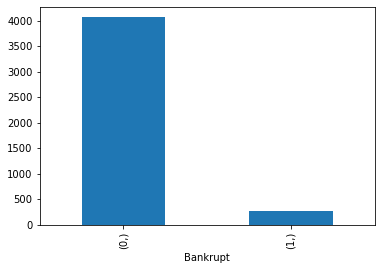

In [25]:
y_train.value_counts().plot(kind='bar')

- The above plot shows that most (more than 90%) of the training data do not go bankrupt in the following year, therefore the dataset is `imbalanced`. 
- I will apply Resampling method to deal with the imbalanced data in later sections in order to have better performance in machine learning models.

## Check the correlation between features
I expect that several features might be highly correlated since some of them are calculated using similar terms, so I display the `correlation matrix` and use `heatmap` to visualize it

In [26]:
X_train.corr()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
X1,1.000000,-0.066482,0.070248,0.012557,0.000321,0.863912,0.999984,0.009189,-0.005465,-0.925436,...,0.004894,0.009634,0.005114,-0.008544,0.000801,0.000357,-0.077302,-0.003969,0.014390,-0.754174
X2,-0.066482,1.000000,-0.902316,-0.014441,-0.009578,-0.086986,-0.066797,-0.019351,0.198041,-0.304098,...,-0.056229,-0.064499,-0.004455,0.066551,0.005053,-0.000029,0.051653,0.068162,-0.017516,0.011394
X3,0.070248,-0.902316,1.000000,0.020030,0.005619,0.083018,0.070583,0.016024,-0.143789,0.287230,...,0.053608,0.050041,0.003074,-0.043424,-0.003047,-0.000472,-0.048684,-0.072804,0.022928,-0.006139
X4,0.012557,-0.014441,0.020030,1.000000,0.000728,-0.000527,0.012822,0.911810,-0.011067,0.014618,...,-0.000312,0.000021,0.001192,-0.002127,-0.001706,-0.002579,-0.003625,-0.002606,0.978679,0.011652
X5,0.000321,-0.009578,0.005619,0.000728,1.000000,0.000558,0.000304,0.001391,-0.054003,0.003554,...,0.002209,0.011115,0.000105,-0.010146,-0.000676,0.000047,-0.003448,-0.123155,0.000472,-0.000859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X60,0.000357,-0.000029,-0.000472,-0.002579,0.000047,0.000073,0.000399,-0.002847,-0.005121,-0.000166,...,-0.001696,0.002290,0.000374,-0.001421,-0.000662,1.000000,-0.003134,0.001360,-0.008415,-0.000785
X61,-0.077302,0.051653,-0.048684,-0.003625,-0.003448,-0.034471,-0.077374,-0.003549,0.130486,-0.049071,...,-0.012482,-0.006349,-0.001660,0.001922,0.001394,-0.003134,1.000000,-0.002388,0.004092,-0.001569
X62,-0.003969,0.068162,-0.072804,-0.002606,-0.123155,-0.005390,-0.004064,-0.001612,-0.030979,-0.023631,...,-0.011775,-0.541727,-0.003025,0.689947,-0.000894,0.001360,-0.002388,1.000000,-0.004693,-0.002976
X63,0.014390,-0.017516,0.022928,0.978679,0.000472,0.000005,0.015338,0.893252,0.018572,0.017798,...,-0.000957,0.002875,0.001605,-0.007224,-0.001444,-0.008415,0.004092,-0.004693,1.000000,0.013223


<AxesSubplot:>

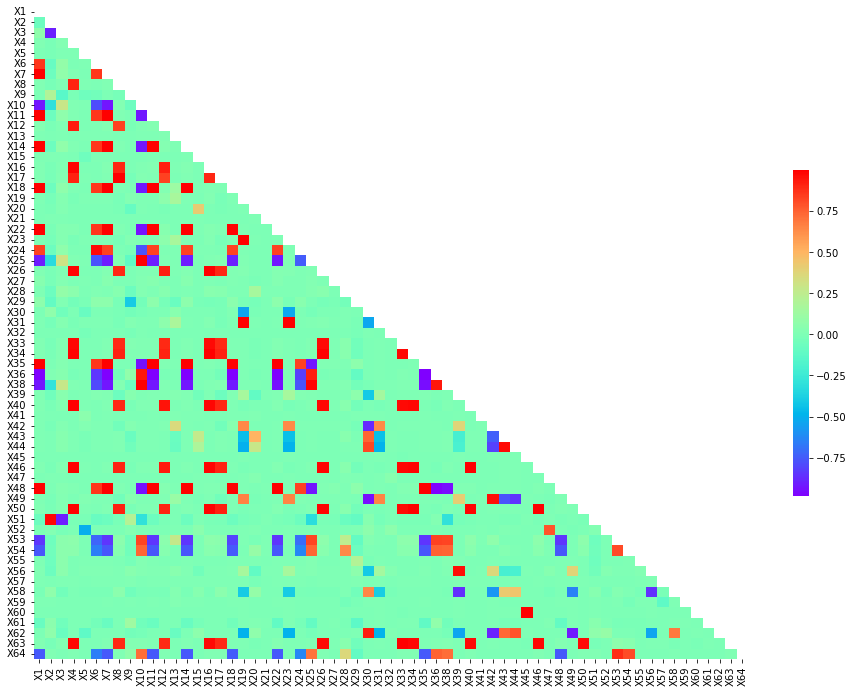

In [27]:
# visualize the correlation using heatmap
import seaborn as sns
fig,ax = plt.subplots(figsize=(16,12))

corr = X_train.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask=mask,cbar_kws={'shrink':.5},cmap='rainbow',square=False)

According to this heatmap, the expectation is matched since there are many pairs of features that are highly correlated; for example:
- X2 (total liabilities / total assets) and X3 (working capital / total assets) -> their high correlation might due to they share the same denominator
- X6 (retained earnings / total assets) and X7 (EBIT / total assets) -> they also share the same denominator and retained earnings are similar to EBIT
- X53 (equity / fixed assets) and X64 (sales / fixed assets)
- X10 (equity / total assets) with X22 (profit on operating activities / total assets) or X36 (constant capital / total assets)
- ...

I will deal with this issue using the Principal Component Analysis in later sections to achieve dimensionality reduction.

## Check the scales of features

It is known that some machine learning models such as Logistic Regression are very sensitive to the scale of features. In order not to impact the performance of such models, I want to check whether we need to apply scaling transformation on the dataset using `boxplot` in the `seaborn` library.

<Figure size 1440x1152 with 0 Axes>

[None]

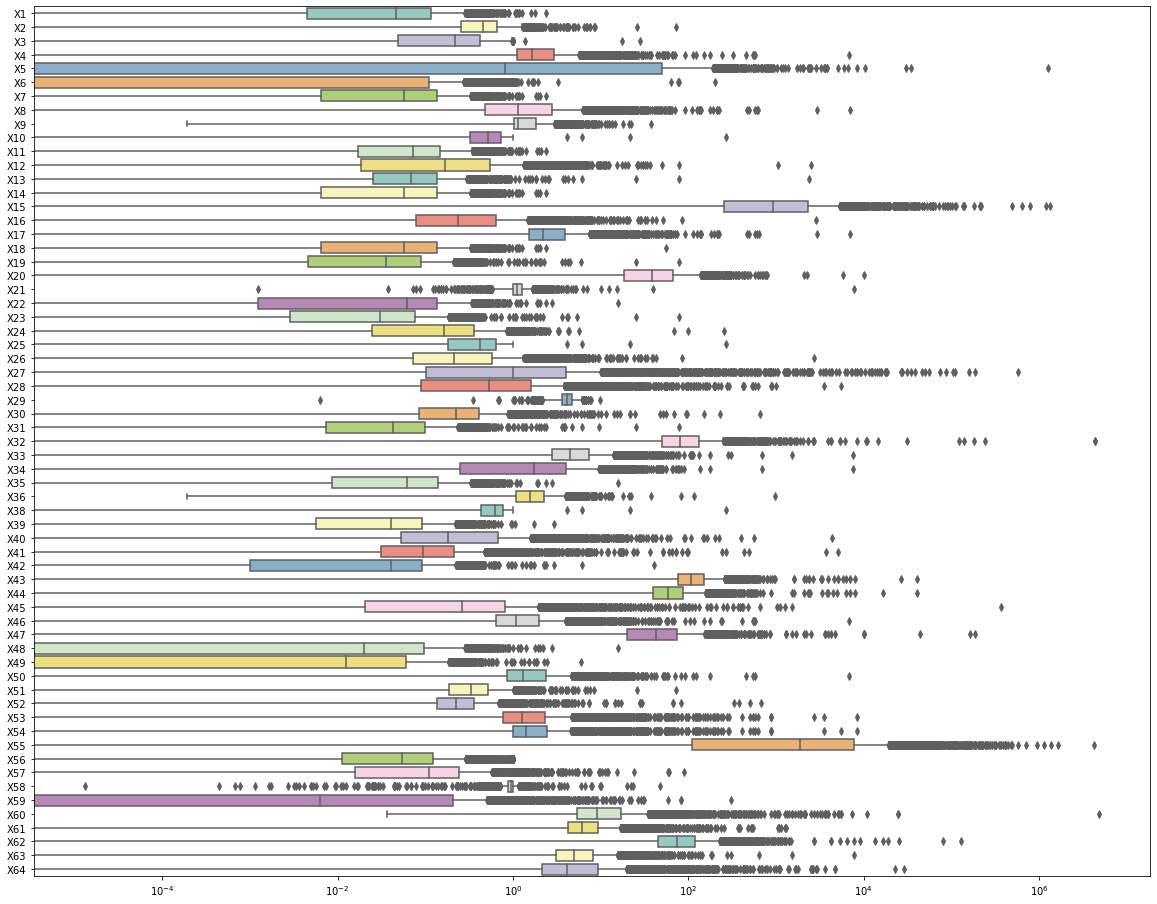

In [28]:
plt.figure(figsize=(20,16))
ax = sns.boxplot(data=X_train,orient='h', palette="Set3")
ax.set(xscale='log')
plt.show()

Based on this boxplot, we can see that:
- features have different scales with each other
- some features have much larger scales than other features
- also exists several outliers

It would be not good to our model performance if we just drop all the outliers. Therefore, some necessary transformation such as scaling might be needed.

# Pre-processing the data

In previous sections, I have already done several steps of data pre-processing such as:
- convert the features to be numeric
- drop the feature (X37) with more than one-third of the number of observations' missing value 

However, as discussed in the former section, the data have some other problems so that they need to be further processed here:
- Some features are highly correlated with each other & models such as Logistic Regression and SVM is very sensitive to high correlation -> dimensionality reduction technique such as PCA is necessary for them
- Features have different scales & PCA is very sensitive to scales -> scaling is required before PCA
- The data is imbalanced -> data augmentation for the minority class is needed
- There are many outliers and they could be bad for our classification models, but simply dropping them is not a good choice -> other process such as imputation is needed

## Imputation: Dealing with Missing Data and Outliers

Although I have dropped the feature 'X37' with the most missing values, there are other features that still have many missing values. Here I choose to use the `KNNImputer` to impute the missing values. 

In [29]:
# I decide to use KNNImputer 
from sklearn.impute import KNNImputer
imputer = KNNImputer()

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)

In [30]:
X_train.isnull().sum().sum()

0

Now the missing value becomes to be zero. Then I am going to deal with the outliers and there will basically be two steps: 1. set all outliers (which are outside of 3 standard deviations) to be NaN; 2. impute all the new missing values again using `KNNImputer`. 

I choose to perform missing value imputation twice, one before outlier treatment and other after outlier treatment, because in first step I want to treat all missing values with appropriate values, by doing this, I will treat all missing values; and after this, an outlier treatment will change the outlier to be NaN which can again be filled by missing value imputation.

In [31]:
from scipy import stats

# A function that sets all the outliers to be NaN
def trans_outliers_to_nan(df, z_thresh=3):
    identifier = df.select_dtypes(include=[np.number]).apply(lambda x: np.abs(stats.zscore(x)) < z_thresh)
    return df[identifier]

In [32]:
X_train = trans_outliers_to_nan(X_train)

# apply the KNN Imputer again after setting outliers to be NaN 
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)

## Dealing with the imbalanced data

I have shown that the data is imbalanced since only 6.18% of the companies are 'Bankrupt', which means that 'Bankrupt' here is an under-presented class. As a result, training is may be biased to not do as well on examples from this class. 

However, this minority class "Bankrupt' here is the most important class and we require high accuracy in it. Therefore, I will apply a method called Resampling here to oversample the minority class. Here, `SMOTE` in `imblearn` library will be used to implement the **Synthetic Minority Over-sampling Technique** to oversample the 'Bankrupt' class.

Here, the `sampling_strategy` parameter in `SMOTE` will be set to default as 'auto', which will oversample the minority class to have the same number as the majority class.

In [33]:
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

In [34]:
oversample = SMOTE(random_state = 42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [35]:
y_train.value_counts()

Bankrupt
0           4068
1           4068
dtype: int64

## Scaling

As mentioned, features have different scales. Moreover, since several models are sensitive to high correlation, PCA will be applied to the data and it will assume all the features are centered (with mean 0) and it is very sensitive to scales.

Thus, I choose to transform each feature into standardized values with mean 0 and unit standard deviation using `StandardScaler` in `sklearn` for classification models such as Logistic Regression and SVM.

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [38]:
X_train_scale.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,0.522627,-0.311684,0.829192,-0.096194,0.182464,0.383317,0.583319,-0.176593,-0.400216,0.323680,...,-0.123291,0.696376,0.216126,-0.634323,-0.196975,0.229694,-0.736475,-0.026150,-0.328221,0.313354
1,0.129639,-0.954380,1.418270,0.262836,0.218982,0.759864,0.111092,0.205148,-0.653436,0.685617,...,0.560674,-0.102354,0.000956,0.096224,-0.196975,-0.063707,-0.235442,-0.375717,-0.027125,0.048760
2,0.433609,0.508924,0.069467,-0.191080,-0.396290,0.166956,0.395877,-0.287862,-0.399758,-0.252346,...,-0.124663,1.901589,0.839832,-1.736327,-0.196975,-0.102236,-0.261525,0.419228,-0.410622,3.885103
3,0.112159,-0.127052,0.090001,-0.168121,-0.035739,0.195653,0.092700,-0.214823,-0.767034,0.194075,...,0.043574,0.096452,0.002368,0.035187,0.224945,-0.099209,0.073325,-0.046450,-0.321279,-0.239218
4,-0.034600,0.567931,-0.782535,-0.285176,-0.077310,0.079375,-0.062333,-0.292166,-0.850446,-0.293814,...,-0.869534,0.602315,-0.415636,-0.547059,4.547139,-0.029536,0.079932,0.133663,-0.369410,-0.247388


## Applying PCA to achieve dimensionality reduction

As discussed in the above section, some features are highly correlated with each other and this will affect the performance of several models. Since I do not want to drop any other feature, `Principal Component Analysis` will be applied before training some of our models.

In [39]:
from sklearn.decomposition import PCA

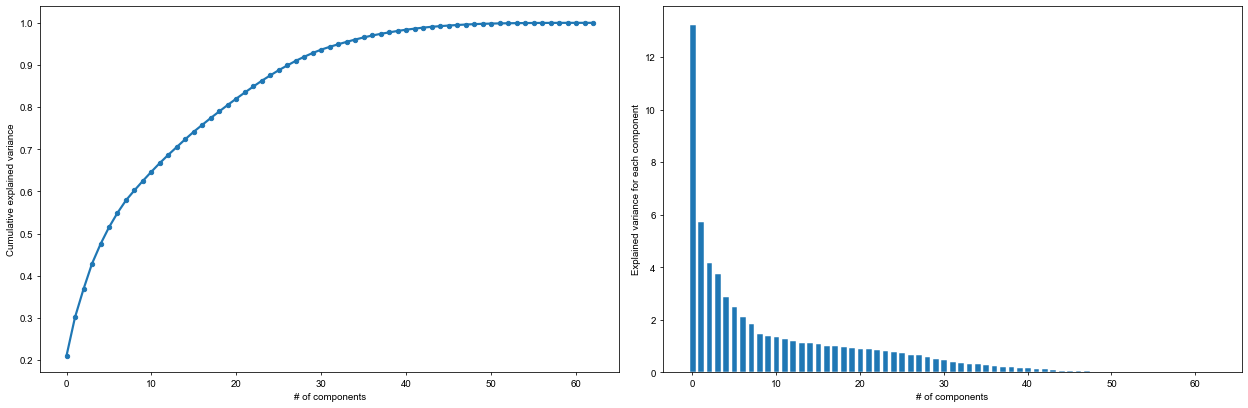

In [40]:
pca = PCA().fit(X_train_scale)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), dpi=70, facecolor='w', edgecolor='k')
ax0, ax1 = axes.flatten()

sns.set('talk', palette='colorblind')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

ax0.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
ax0.set_xlabel('# of components')
ax0.set_ylabel('Cumulative explained variance');

ax1.bar(range(X_train_scale.shape[1]),pca.explained_variance_)
ax1.set_xlabel('# of components')
ax1.set_ylabel('Explained variance for each component');

plt.tight_layout()
plt.show();

In [41]:
variance_goal_pct = 95
features_for_goal= np.size(np.cumsum(pca.explained_variance_ratio_)>0.95) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.95)
print("To capture {f:d}% of variance we need {d:d} synthetic features.".format(f=variance_goal_pct, d=features_for_goal))

To capture 95% of variance we need 33 synthetic features.


According to the figure and analysis, we need 33 components to capture 95% of the variance.

In [42]:
pca_95 = PCA(n_components = features_for_goal)
X_train_pca = pd.DataFrame(pca_95.fit_transform(X_train_scale)).add_prefix("component_")

In [43]:
X_train_pca.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32
0,-2.324395,-0.723026,0.093080,-0.621080,0.989587,2.116950,-0.461838,-0.027343,-0.854475,-0.809899,...,0.469656,-0.385310,0.275125,-0.066770,0.706971,-0.991250,-0.220253,0.413410,0.603439,-0.161676
1,-1.958782,0.911333,0.646129,-1.752832,-0.163980,0.643190,-0.275030,0.070119,0.945317,0.244593,...,-0.281712,-0.187291,-0.118768,-0.127642,0.167331,0.183559,0.170402,-0.039624,0.222154,-0.148505
2,-0.732432,-0.856653,0.062305,0.275720,1.847404,3.567368,-3.639407,0.557155,-0.092389,-0.214554,...,1.374148,1.085434,-0.224904,0.004410,-1.590917,-0.993482,-0.439319,-0.051429,0.305443,1.261397
3,-0.406411,-0.963567,0.726635,-0.797901,0.604869,-0.497023,0.004191,-0.041911,0.484317,0.484451,...,0.096756,0.289875,0.060974,0.236202,-0.204050,0.233513,0.181632,-0.112233,0.049514,-0.054244
4,0.577242,-1.325831,-0.061955,-0.302100,0.203062,-0.844602,0.212413,0.291204,1.364701,0.868280,...,-0.299006,2.354235,0.744432,-0.547584,0.104734,-0.176946,0.167939,0.231203,-0.083406,0.074079


## Implementing the same transformation process on test set
Before training our models, I would like to do the same transformation and preprocessing to the test set

In [44]:
X_test = X_test.apply(pd.to_numeric,errors='coerce')
X_test.drop('X37',axis=1,inplace=True)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)
# deal with outliers
X_test = trans_outliers_to_nan(X_test)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)

# scaling and PCA for models that are sensitive to high correlation and scales such as Logistic Regression 
X_test_scale = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_test_pca = pd.DataFrame(pca_95.fit_transform(X_test)).add_prefix("component_")

In [45]:
X_test_pca.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32
0,-5914.214296,-909.913340,-102.954676,-12.647074,-71.449719,-4.512801,-19.201632,56.429751,28.954669,11.823696,...,0.772334,-0.354355,0.883552,0.312014,-1.172089,1.528368,-0.757849,-0.301639,0.058819,-0.079633
1,-5190.051279,-2426.744810,-44.290752,-15.631549,-42.117850,-16.833121,-16.104049,27.758683,6.740608,23.440190,...,-0.211543,-0.192381,-0.168114,0.076581,-0.178168,-0.159878,-0.056340,0.188208,-0.229968,0.530593
2,-6798.119681,10317.264186,-28.226559,-15.506646,-110.130039,90.346274,-4.443375,103.113092,18.896511,-16.627958,...,-0.056977,-0.001066,-0.000440,1.143862,0.325273,0.124838,0.330780,-0.084954,-0.125818,0.127634
3,-3766.853194,-435.908397,1.161924,-16.725453,-28.527303,-18.544085,-21.408721,17.699702,-8.479063,13.783748,...,0.386128,-0.142452,0.544194,-0.311874,-0.872290,0.286170,-0.209111,0.330292,0.391319,-0.302998
4,4978.007134,178.398672,-96.386745,-29.958944,28.006767,-49.131228,-21.627061,-85.804119,47.449479,-22.931044,...,-1.172074,0.807388,0.211787,-0.161414,0.221048,0.121497,-0.732749,0.302953,0.132348,-0.503075


# Train Models

In this section, I will include several other popular classification models and then compare their performance based on the performance metrics that we have already set. 

Note: Here I only train and fit these models without specially setting any hyperparameters since there will be a `Fine Tune` section that mainly focuses on adjusting hyperparameters to observe the performance after this section.

## Baseline model: dummy classifier
A baseline model is a 'naive' model that I will start off, which might be used to be compared with more complex models and then get the model that I endeavor to create.

Here I use a model that always predicts the class that occurs the most frequent (which is 'Not go Bankrupt' -> 0 here) as the baseline model.

In [46]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
dummy_in_sample = dummy.predict(X_train)
dummy_pred = dummy.predict(X_test)

name='Baseline model (Most Frequent)'
score_in_sample = accuracy_score(y_train, dummy_in_sample)
score_out_of_sample = accuracy_score(y_test,dummy_pred)
recall = recall_score(y_test, dummy_pred, pos_label=1, average="binary")
precision = precision_score(y_test, dummy_pred, pos_label=1, average="binary")
print('\t{m:s} : In-Sample Accuracy: {a:3.1%}, Out-of-Sample Accuracy: {b:3.1%}, Recall: {r:3.1%}, Precision: {p:3.1%}'.format(m=name,
                                                                                                                               a=score_in_sample, 
                                                                                                                               b=score_out_of_sample,
                                                                                                                               r=recall,
                                                                                                                               p=precision))                                                           

	Baseline model (Most Frequent) : In-Sample Accuracy: 50.0%, Out-of-Sample Accuracy: 91.7%, Recall: 0.0%, Precision: 0.0%


In this model, since we predict everything to be the class '0', the number of true positive is 0, which leads to zero recall (which we value the most) and precision rate. 

Meanwhile, the accuracy score for this dummy model is almost 92%, which seems to suggest that even the dummy model is good enough. However, our dataset is proved to be very imbalanced, the accuracy score is not a good performance metric in our context since we will get a high accuracy if we predict all the results as the majority class.

Therefore, we need more complex model to reduce false negatives (i.e. get higher recall rates) for this classification problem.

## Selected Models
Since the baseline model is displayed, I am going to apply six popular classification models to find the model that stands out based on the performance metrics that I have set.

In [47]:
# models that are sensitive to scales
logistic_clf = LogisticRegression(random_state= 42)
svc = SVC(random_state= 42)

# models that are not sensitive to scales
nb_clf = GaussianNB()
rf_clf = RandomForestClassifier(random_state= 42)
gbm = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state= 42)

These models are basically divided into two groups:
- Models that are sensitive to scales and high correlation: Logistic Regression and Support Vector Machine
- Models that are insensitive: Naive Bayes, Random Forest, Gradient Boosting and ADA Boost

This first group will be trained and tested by the data that have been scaled and applied PCA while the second group will be trained and tested by the dataset without doing these since scaling is a monotonic transformation and most of these models are tree-based algorithms which do not need normalization.

## Fit the models

### The 1st group: Logistic Regression Classifier & Support Vector Classifier

In [48]:
models_scale = [logistic_clf, svc]

def metrics_scale(model, X_train, y_train, X_test, y_test):
    metrics = {} 
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test) 
    
    metrics['Accuracy_test'] = accuracy_score(y_test , y_pred)  
    
    metrics['Recall_test'] = recall_score(y_test , y_pred)
    
    metrics['Precision_test'] = precision_score(y_test , y_pred)
    
    metrics['F1_Score_test'] = f1_score(y_test , y_pred)
    
    return metrics

# Initializing a dictionary to store training and testing data
model_scale_performance = {} 
for model in models_scale: 
    model_name = model.__class__.__name__
    model_scale_performance[model_name]  = {}
    model_scale_performance[model_name] = metrics_scale(model, X_train_pca, y_train, X_test_pca, y_test)

In [49]:
pd.DataFrame(model_scale_performance)

,LogisticRegression,SVC
Accuracy_test,0.639004,0.917012
Recall_test,0.075000,0.000000
Precision_test,0.021429,0.000000
F1_Score_test,0.033333,0.000000


### The second group: Naive Bayes, Random Forest, Gradient Boosting & Ada Boost

In [50]:
models = [nb_clf, rf_clf, gbm, ada]

def metrics(model, X_train, y_train, X_test, y_test):
    metrics = {} 
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test) 
    
    metrics['Accuracy_test'] = accuracy_score(y_test , y_pred)  
    
    metrics['Recall_test'] = recall_score(y_test , y_pred)
    
    metrics['Precision_test'] = precision_score(y_test , y_pred)
    
    metrics['F1_Score_test'] = f1_score(y_test , y_pred)
    
    return metrics

model_performance = {} # Initializing a dictionary to store training and testing data
for model in models: # these are our objects that we instantiated above. We loop through them
    model_name = model.__class__.__name__
    model_performance[model_name]  = {}
    model_performance[model_name] = metrics(model, X_train, y_train, X_test, y_test)

In [51]:
pd.DataFrame(model_performance)

,GaussianNB,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
Accuracy_test,0.350622,0.923237,0.904564,0.856846
Recall_test,0.900000,0.475000,0.725000,0.625000
Precision_test,0.104348,0.542857,0.453125,0.316456
F1_Score_test,0.187013,0.506667,0.557692,0.420168


Based on the results of the performance metrics, it could be suggested that:
- For the 1st group:
    - For Logistic Regression, the accuracy score seems to be okay, but all other metrics are not good, this might because it predicts most cases as 'negative' so that its accuracy becomes good since our data is imbalanced.
    
    - For SVM, the accuracy score is high, but all other metrics are zero and the reason might be that it predicts almost all results as 'negative'. Since we value the 'recall' rate the most, this model is obviously not the one I expect.
- For the 2nd group:
    - Naive Bayes: it seems to have a quite high recall rate, however, its accuracy and precision are very poor. I guess it might predict most cases as 'positive', although it reduces the 'false negative' rate as we want, it raises the 'false positive' rate too much.
    
    - Random Forest: this model seems to be predictive in this classification problem since all the metrics are high. However, we value the 'recall' the most, so I would like to fine tune this model in further sections to see whether it could become the one that I endeavor to create.
    
    - Gradient Boosting: its performance metrics are even better than 'random forest', it has a higher recall score as we want and in the meantime, the accuracy score and precision are also high.
    
    - Ada Boost: this model also performs good, but it is kind of being similar to the last one since they are both boosting models. Therefore, I would like to focus more on Gradient Boosting model rather than this one since the former one has better performance in every aspect.
    
In the next subsection, I would like to do error analysis to check some of my guesses about these models here and gain more insights.

## Error Analysis

In the part, `Confusion Matrix` of all the models will be presented to analyze the deep reasons of their performance (whether perform well or not). In order to be clearer, I use two different colormaps to display the two groups, respectively.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


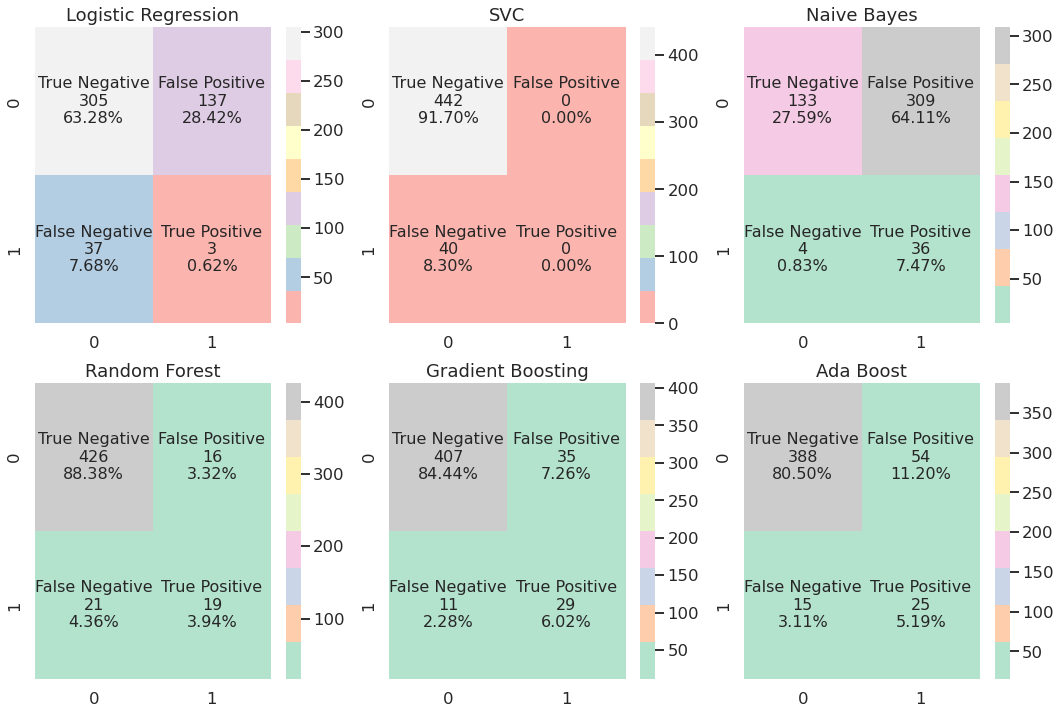

In [52]:
from sklearn.metrics import confusion_matrix

# for the 1st group
model_scale = [logistic_clf, svc]
def confusion_scale(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)  # Training
    y_pred = model.predict(X_test) # Predicts
    cm = confusion_matrix(y_test, y_pred)
    return cm

model_scale_cm = {} # Initializing a dictionary to store training and testing data
for model in models_scale: 
    model_name = model.__class__.__name__
    model_scale_cm[model_name]  = {}
    model_scale_cm[model_name] = confusion_scale(model, X_train_pca, y_train, X_test_pca, y_test)
    
    
# for the 2nd group
models = [nb_clf, rf_clf, gbm, ada]
def confusion(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)  # Training
    y_pred = model.predict(X_test) # Predicts
    cm = confusion_matrix(y_test,y_pred)
    return cm

model_cm = {} # Initializing a dictionary to store training and testing data
for model in models: 
    model_name = model.__class__.__name__
    model_cm[model_name]  = {}
    model_cm[model_name] = confusion(model, X_train, y_train, X_test, y_test)
    
    
# plot all the confusion matrices
f, ((ax1, ax2, ax4),(ax3, ax5, ax6)) = plt.subplots(2,3, figsize=(18,12))

lgr = model_scale_cm['LogisticRegression']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in lgr.flatten()]
percent = ['{0:.2%}'.format(value) for value in lgr.flatten()/np.sum(lgr)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(lgr,annot=show,fmt='',cmap='Pastel1',annot_kws={'size':16},ax=ax1);
ax1.set_title('Logistic Regression')

svc_cm = model_scale_cm['SVC']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in svc_cm.flatten()]
percent = ['{0:.2%}'.format(value) for value in svc_cm.flatten()/np.sum(svc_cm)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(svc_cm,annot=show,fmt='',cmap='Pastel1',annot_kws={'size':16},ax=ax2);
ax2.set_title('SVC')

rfc = model_cm['RandomForestClassifier']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in rfc.flatten()]
percent = ['{0:.2%}'.format(value) for value in rfc.flatten()/np.sum(rfc)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(rfc,annot=show,fmt='',cmap='Pastel2',annot_kws={'size':16},ax=ax3);
ax3.set_title('Random Forest')

gnb = model_cm['GaussianNB']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in gnb.flatten()]
percent = ['{0:.2%}'.format(value) for value in gnb.flatten()/np.sum(gnb)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(gnb,annot=show,fmt='',cmap='Pastel2',annot_kws={'size':16},ax=ax4);
ax4.set_title('Naive Bayes')

gbm = model_cm['GradientBoostingClassifier']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in gbm.flatten()]
percent = ['{0:.2%}'.format(value) for value in gbm.flatten()/np.sum(gbm)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(gbm,annot=show,fmt='',cmap='Pastel2',annot_kws={'size':16},ax=ax5);
ax5.set_title('Gradient Boosting')

ada = model_cm['AdaBoostClassifier']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in ada.flatten()]
percent = ['{0:.2%}'.format(value) for value in ada.flatten()/np.sum(ada)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(ada,annot=show,fmt='',cmap='Pastel2',annot_kws={'size':16},ax=ax6);
ax6.set_title('Ada Boost')

plt.show();

According to the above confusion matrices,
- As we expect, Logistic Regression predicts the most cases as 'negative'. Meanwhile, this model is not good at predicting 'true positive' since it always predicts companies that do not go bankrupt as 'bankrupt' whereas predicts companies that truly go bankrupt as 'not bankrupt'. As a result, all of its metrics are not good.
- The SVM also meets our guess since it predicts all companies as 'not bankrupt' so that it has a very high accuracy but very poor performance on any other metrics.
- For Naive Bayes, it has high recall rate because it sacrifices the accuracy and precision score by predicting most of the companies as 'bankrupt' to get a higher true positive rate and a lower false negative rate. However, the false positive rate is too high, although we do not value it the most, this model is obviously not the one that we want.
- As for Random Forest model, it does good in every aspect except for in the tradeoff between recall and precision, we lean towards the 'recall' rate, but it has a higher precision rate.
- As for Gradient Boosting model, it does well for every metrics: higher true positive rate, lower false negative and false positive rates as we expect.
- Ada Boost is similar to Gradient Boosting, but it does worse in every section than the later one.

At the beginning of this project, I create a new metric based on the description of this classification problem, since we could assume it is 5 times worse to fail to identify a company that will go bankrupt than it is to fail to identify a company that won't go bankrupt, the false negative is 5 times worse than the false positive. Thus, I want to also compare these models with this new metric here to better explain my choice for models that I want to do fine tuning in the next section:

$$ Logistic\ Regression = 5 * 7.68 + 1 * 28.42 = 66.82$$

$$ Support\ Vector = 5 * 8.30 + 1 * 0 = 41.5$$

$$ Naive\ Bayes = 5 * 0.83 + 1 * 64.11 = 68.26$$

$$ Random\ Forest = 5 * 4.36 + 1 * 3.12 = 24.92$$

$$ Gradient\ Boosting = 5 * 2.28 + 1 * 7.26 = 18.66$$

$$ Ada\ Boost = 5 * 3.11 + 1 * 11.20 = 26.75$$

This new metric takes our tradeoff between recall and precision into consideration. According to all the analysis above, I decide to drop three models with the following reason:
- Support Vector Machine: although its new metric is not so bad, its recall and precision are all zero, which is not ideal.
- Naive Bayes: although it has a high recall rate, as our new metric shows, it does the worst work in the tradeoff between recall and precision.
- Ada Boost: this model is good, but it is not as good as its similar model: Gradient Boosting, so I decide to drop this one and do further research on Gradient Boosting.

As a result, the following three models are selected to do further fine tuning with hyperparameters:
- Logistic Regression: I would like to see whether it can be adjusted into a better model.
- Random Forest: if it can be tuned to have a preference on recall rather than precision, it might become the model that I expect.
- Gradient Boosting: it performs the best in this context based on the new metric since here we want to minimize false negatives and in the meantime, do not raise too many false positives. It will be ideal if it could become better after tuning. 

# Fine tune using Grid Search

In this section, `Grid Search` will be applied to tune the hyperparameters for the three models that I select. Based on our objective, the `scoring` parameter in the `GridSearchCV` will be set as `recall` since we want to minimize the false negatives.

In [53]:
from sklearn.model_selection import GridSearchCV

## Logistic Regression

In [54]:
param_grid = {'C': [0.01, 0.1, 1, 2, 10, 100], 'penalty': ['l1', 'l2'],'solver':['newton-cg', 'lbfgs', 'liblinear'],'random_state':[42]}
logistic_clf = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(logistic_clf, param_grid, scoring='recall',cv=5, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_pca, y_train.values.ravel())

lr = grid_search.best_estimator_
name='Logistic Regression(Fine Tuned)'
score_out_of_sample = accuracy_score(y_test,lr.predict(X_test_pca))
recall = recall_score(y_test, lr.predict(X_test_pca), pos_label=1, average="binary")
precision = precision_score(y_test, lr.predict(X_test_pca), pos_label=1, average="binary")
f1 = f1_score(y_test , lr.predict(X_test_pca))
print(grid_search.best_params_)
print('\t{m:s} : Out-of-Sample Accuracy: {b:3.1%}, Recall: {r:3.1%}, Precision: {p:3.1%}, F-1 score: {f:3.1%}'.format(m=name,
                                                                                                                      b=score_out_of_sample,
                                                                                                                      r=recall,
                                                                                                                      p=precision,
                                                                                                                      f=f1)) 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 2, 10, 100],
                         'penalty': ['l1', 'l2'], 'random_state': [42],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             return_train_score=True, scoring='recall')

{'C': 10, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
	Logistic Regression(Fine Tuned) : Out-of-Sample Accuracy: 63.9%, Recall: 7.5%, Precision: 2.1%, F-1 score: 3.3%


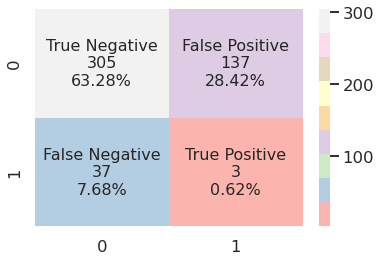

In [55]:
cm = confusion_matrix(y_test,lr.predict(X_test_pca))
lbs =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percent = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(cm,annot=show,fmt='',cmap='Pastel1',annot_kws={'size':16});

The new metric for this tuned Logistic Regression is:

$$ Tuned\ Logistic = 5 * 7.68 + 1 * 28.42 = 66.82 $$

All of the metrics are the same as the one before tuning and it is far worse than we expect. Therefore, I will drop this model.

## Random Forest

In [56]:
param_grid={'n_estimators': [10, 50, 100], 'max_depth': [5, 8, 15, 25, 30],'min_samples_split': [2, 5, 10, 15, 100],'min_samples_leaf': [1,2,3,4]}
rf_clf = RandomForestClassifier()
grid_search = GridSearchCV(rf_clf, param_grid, scoring='recall',cv=5, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

rf = grid_search.best_estimator_
name='Random Forest(Fine Tuned)'
score_out_of_sample = accuracy_score(y_test,rf.predict(X_test))
recall = recall_score(y_test, rf.predict(X_test), pos_label=1, average="binary")
precision = precision_score(y_test, rf.predict(X_test), pos_label=1, average="binary")
f1 = f1_score(y_test , rf.predict(X_test))
print(grid_search.best_params_)
print('\t{m:s} : Out-of-Sample Accuracy: {b:3.1%}, Recall: {r:3.1%}, Precision: {p:3.1%}, F-1 score: {f:3.1%}'.format(m=name,
                                                                                                                      b=score_out_of_sample,
                                                                                                                      r=recall,
                                                                                                                      p=precision,
                                                                                                                      f=f1)) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 15, 25, 30],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [10, 50, 100]},
             return_train_score=True, scoring='recall')

{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Random Forest(Fine Tuned) : Out-of-Sample Accuracy: 92.9%, Recall: 47.5%, Precision: 59.4%, F-1 score: 52.8%


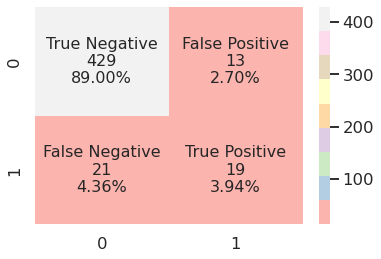

In [57]:
cm = confusion_matrix(y_test,rf.predict(X_test))
lbs =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percent = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(cm,annot=show,fmt='',cmap='Pastel1',annot_kws={'size':16});

The new metric for this tuned Random Forest model is:

$$ Tuned\ Random\ Forest = 5 * 4.36 + 1 * 3.53 = 25.33$$

In this context, Random Forest performs even worse after tuning since both of its recall rate and new metric become lower even though the accuracy and precision are higher. In addition, since the original Random Forest model before tuning is not as good as Gradient Boosting model in the balancing of recall and precision since we prefer higher recall rather than precision. Therefore, I will also drop this model.

## Gradient Boosting

In [58]:
# the score_method for Grid Search is 'recall', which we value the most
score_method = 'recall'

# the base/original gradient boosting model without specially set any hyperparameter
gbm0 = GradientBoostingClassifier(random_state=42)
gbm0.fit(X_train, y_train.values.ravel())

# tune n_estimaters and max_depth
param_trees = {'n_estimators': [i for i in range(10, 101, 30)],
              'max_depth': [i for i in range(2,6,1)]}
gsearch1 = GridSearchCV(estimator = gbm0, 
                        param_grid = param_trees, 
                        scoring=score_method,
                        n_jobs=-1,
                        cv=5
                       )
gsearch1.fit(X_train, y_train.values.ravel())

# tune min_samples_split, min_samples_leaf based on the model that has tuned n_estimaters and max_depth
param_tree2 = {'min_samples_split': [i for i in range(10,51,20)],
              'min_samples_leaf': [i for i in range(10,51,20)]}
gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_, 
                        param_grid = param_tree2, 
                        scoring=score_method,
                        n_jobs=-1,
                        cv=5)
gsearch2.fit(X_train, y_train.values.ravel())

# tune learning_rate paired with n_estimators
# based on the best value of n_estimators tuned in gsearch1
# and other hyperparameters that tuned in gsearch2
n_estimator = gsearch1.best_params_['n_estimators']
param_tree3 = [{'learning_rate': [0.1],
              'n_estimators': [n_estimator]},
              {'learning_rate': [0.1*5],
              'n_estimators': [n_estimator//5]},
              {'learning_rate': [0.1/10],
              'n_estimators': [n_estimator*10]}]
gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_, 
                        param_grid = param_tree3, 
                        scoring=score_method,
                        n_jobs=-1,
                        cv=5)
gsearch3.fit(X_train, y_train.values.ravel())
print('Best score: ', gsearch3.best_score_)                 

# best estimator
gbm_tuned = gsearch3.best_estimator_

GradientBoostingClassifier(random_state=42)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'n_estimators': [10, 40, 70, 100]},
             scoring='recall')

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [10, 30, 50],
                         'min_samples_split': [10, 30, 50]},
             scoring='recall')

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=5,
                                                  min_samples_leaf=10,
                                                  min_samples_split=30,
                                                  random_state=42),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.1], 'n_estimators': [100]},
                         {'learning_rate': [0.5], 'n_estimators': [20]},
                         {'learning_rate': [0.01], 'n_estimators': [1000]}],
             scoring='recall')

Best score:  0.9842718599176162


Here, `gbm_tuned` is the best model found by Grid Search after tuning several hyperparameters, now I would test its performance using our test set.

In [59]:
gbm_tuned_pred = gbm_tuned.predict(X_test)
name = 'gbm1'
score_out_of_sample = accuracy_score(y_test,gbm_tuned_pred)
recall = recall_score(y_test, gbm_tuned_pred, pos_label=1, average="binary")
precision = precision_score(y_test, gbm_tuned_pred, pos_label=1, average="binary")
f1 = f1_score(y_test, gbm_tuned_pred)
print('\t{m:s} : Out-of-Sample Accuracy: {b:3.1%}, Recall: {r:3.1%}, Precision: {p:3.1%}, F-1 score: {f:3.1%}'.format(m=name,
                                                                                                                      b=score_out_of_sample,
                                                                                                                      r=recall,
                                                                                                                      p=precision,
                                                                                                                      f=f1)) 

	gbm1 : Out-of-Sample Accuracy: 91.9%, Recall: 62.5%, Precision: 51.0%, F-1 score: 56.2%


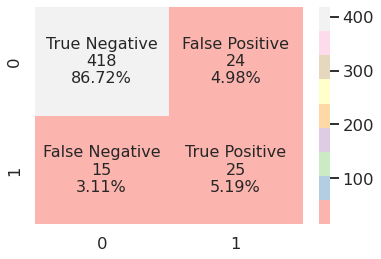

In [60]:
cm = confusion_matrix(y_test,gbm_tuned_pred)
lbs =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percent = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(cm,annot=show,fmt='',cmap='Pastel1',annot_kws={'size':16});

The new metric for this tuned Gradient Boosting model is:

$$ Tuned\ Gradient\ Boosting = 5 * 3.11 + 1 * 4.98 = 20.53$$

We can see that after tuning, this model has higher accuracy score and precision score as well as a higher F-1 score while the recall rate becomes lower. If we are not in this context, this model might be better than the original Gradient Boosting model. However, in this classification model, we mainly focus on `minimizing false negatives` (i.e. higher recall), this tuned model raises all other metrics by reducing the recall rate, which is not something that I expect. This can also be detected through our new metric, which suggests that although many metrics become better, this model even becomes worse in this context since the new metric for the original model is just 18.66.

## Conclusion - Select the final Model

According to the results of fine tune, we have the following findings:
- Logistic Regression: after tuning, its performance is the same as the original one: poor accuracy, poor recall and precision  -> drop this model

- Random Forest: after tuning: good accuracy and good precision, but worse recall score, which is not consistent with our aim: lower false negatives, higher recall -> drop this model

- Gradient Boosting: after tuning: all the metrics except for the recall becomes better, but as the same reason for the Random Forest model, since we value the recall the most, we would not choose to scarifice recall score (from 72.5% to 62.5%) to increase other metrics. If we use this tuned model to deal with this classification problem, it might be more likely to predict companies that will go bankrupt as 'Not bankrupt', which is a serious problem.

    Moreover, according to the new metric, the original model fits our objective better since when adding a five times penalty to false negatives, it has the best performance. Thus, although the original model has lower accuracy and precision score, it could satisfy our main requirement to predict companies that will go bankrupt as 'Bankrupt', which could minimize false negatives and have a higher recall without raising too many false positives (i.e. in the meantime of higher recall, also have a good precision score) 
    
    -> this tuned model is good, but the original Gradient Boosting model is better fit for this classification problem.

Therefore, we choose the `original Gradient Boosting model` (denoted as `gbm0`) as our final model, which has 90.5% accuracy, 72.5% recall (which we value the most) and 45.3% precision score.

# Submission - My Main Model

- Implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set

In [61]:
import pandas as pd
import os

def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # YOUR CODE GOES HERE
    X = X.apply(pd.to_numeric,errors='coerce')
    if 'Id' in X.columns:
        X.set_index('Id', inplace = True)
    X.drop('X37',axis=1,inplace=True)
    
    # dealing with missing value
    X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
    # detect outliers and set them to NaN
    X = trans_outliers_to_nan(X)
    # impute the new missing values again
    X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
    
    predictions = gbm0.predict(X)
    
    return predictions

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [62]:
name = "Gradient Boosting Model"
y_test_pred = MyModel(X_test_original)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test, y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            ))

	Gradient Boosting Model Accuracy: 90.5%, Recall 72.5%, Precision 45.3%


In [63]:
print('My project is done!')

My project is done!


### For Evaluation

I call MyModel for the holdout data to get the predictions for the instuctors to evaluate.

In [64]:
y_hold_pred = MyModel(holdout_data)
y_hold_pred

array([0, 1, 0, ..., 0, 0, 0])

## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [65]:
print("Done!")

Done!
